In [106]:
#import pdb; pdb.set_trace()
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling as pdp

# Jupyter Notebookの中でインライン表示する場合の設定（これが無いと別ウィンドウでグラフが開く）
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/probspace')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")
train.head(10)

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,0,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,1,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
4,4,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
5,5,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
6,6,100000,2,2,2,23,0,-1,-1,0,...,221,-159,567,380,601,0,581,1687,1542,0
7,7,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
8,8,20000,1,3,2,35,-2,-2,-2,-2,...,0,13007,13912,0,0,0,13007,1122,0,0
9,9,200000,2,3,2,34,0,0,2,0,...,2513,1828,3731,2306,12,50,300,3738,66,0


In [0]:
columns = ["id", "credit", "gender", "education", "marrage", "age"]
columns += [f"payment_{i}" for i in range(9,3,-1)]
columns += [f"claim_{i}" for i in range(9,3,-1)]
columns += [f"advance_{i}" for i in range(9,3,-1)]
train.columns = columns + ["target"]
test.columns = columns

In [109]:
test.head(10)

,id,credit,gender,education,marrage,age,payment_9,payment_8,payment_7,payment_6,...,claim_7,claim_6,claim_5,claim_4,advance_9,advance_8,advance_7,advance_6,advance_5,advance_4
0,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
1,1,630000,2,2,2,41,-1,0,-1,-1,...,6500,6500,6500,2870,1000,6500,6500,6500,2870,0
2,2,320000,1,1,1,49,0,0,0,-1,...,194663,70074,5856,195599,10358,10000,75940,20000,195599,50000
3,3,120000,2,2,1,39,-1,-1,-1,-1,...,316,0,632,316,316,316,0,632,316,0
4,4,50000,2,3,2,30,0,0,0,0,...,17163,17878,18931,19617,1300,1300,1000,1500,1000,1012
5,5,500000,1,1,1,58,-2,-2,-2,-2,...,31130,3180,0,5293,5006,31178,3180,0,5293,768
6,6,280000,2,1,2,39,-1,-1,-1,0,...,3968,3868,0,0,0,3968,0,0,0,0
7,7,360000,1,1,1,43,-1,-1,-1,-1,...,3394,6451,26370,9956,8339,3394,12902,27000,0,68978
8,8,80000,2,2,1,36,-1,-1,-1,-1,...,3277,3319,1150,1150,2861,3279,3319,1150,1150,1035
9,9,80000,2,2,1,23,1,2,3,2,...,10205,9898,10123,12034,1650,0,0,379,2091,1


In [110]:
"""
#年齢台の特徴量
train["age_cat"] = (np.floor(train["age"]/10)*10).astype(np.int64)
test["age_cat"] = (np.floor(test["age"]/10)*10).astype(np.int64)
"""
train["payment"] = [0]*len(train)
train["recent_payment"] = [0]*len(train)
test["payment"] = [0]*len(test)
test["recent_payment"] = [0]*len(test)



#一度も支払い遅れがなかったか
col = [f"payment_{i}" for i in range(9,3,-1)]

for i in range(len(train)):
    if all(train[col].iloc[i] <= 0) == True:
      train["payment"][i] = 0
    else:
      train["payment"][i] = 1
      
for i in range(len(test)):
    if all(test[col].iloc[i] <= 0) == True:
      test["payment"][i] = 0
    else:
      test["payment"][i] = 1
      
"""
#直近2ヶ月で支払い遅れがなかったか
col2 = [f"payment_{i}" for i in range(9,7,-1)]

for i in range(len(train)):
    if all(train[col2].iloc[i] <= 0) == True:
      train["recent_payment"][i] = 0
    else:
      train["recent_payment"][i] = 1
      
for i in range(len(test)):
    if all(test[col2].iloc[i] <= 0) == True:
      test["recent_payment"][i] = 0
    else:
      test["recent_payment"][i] = 1
"""    

'\n#直近2ヶ月で支払い遅れがなかったか\ncol2 = [f"payment_{i}" for i in range(9,7,-1)]\n\nfor i in range(len(train)):\n    if all(train[col2].iloc[i] <= 0) == True:\n      train["recent_payment"][i] = 0\n    else:\n      train["recent_payment"][i] = 1\n      \nfor i in range(len(test)):\n    if all(test[col2].iloc[i] <= 0) == True:\n      test["recent_payment"][i] = 0\n    else:\n      test["recent_payment"][i] = 1\n'

In [111]:
train.head(10)

,id,credit,gender,education,marrage,age,payment_9,payment_8,payment_7,payment_6,...,claim_4,advance_9,advance_8,advance_7,advance_6,advance_5,advance_4,target,payment,recent_payment
0,0,20000,2,2,1,24,2,2,-1,-1,...,0,0,689,0,0,0,0,1,1,0
1,1,120000,2,2,2,26,-1,2,0,0,...,3261,0,1000,1000,1000,0,2000,1,1,0
2,2,90000,2,2,2,34,0,0,0,0,...,15549,1518,1500,1000,1000,1000,5000,0,0,0
3,3,50000,1,2,1,57,-1,0,-1,0,...,19131,2000,36681,10000,9000,689,679,0,0,0
4,4,50000,1,1,2,37,0,0,0,0,...,20024,2500,1815,657,1000,1000,800,0,0,0
5,5,500000,1,1,2,29,0,0,0,0,...,473944,55000,40000,38000,20239,13750,13770,0,0,0
6,6,100000,2,2,2,23,0,-1,-1,0,...,567,380,601,0,581,1687,1542,0,0,0
7,7,140000,2,3,1,28,0,0,2,0,...,3719,3329,0,432,1000,1000,1000,0,1,0
8,8,20000,1,3,2,35,-2,-2,-2,-2,...,13912,0,0,0,13007,1122,0,0,0,0
9,9,200000,2,3,2,34,0,0,2,0,...,3731,2306,12,50,300,3738,66,0,1,0


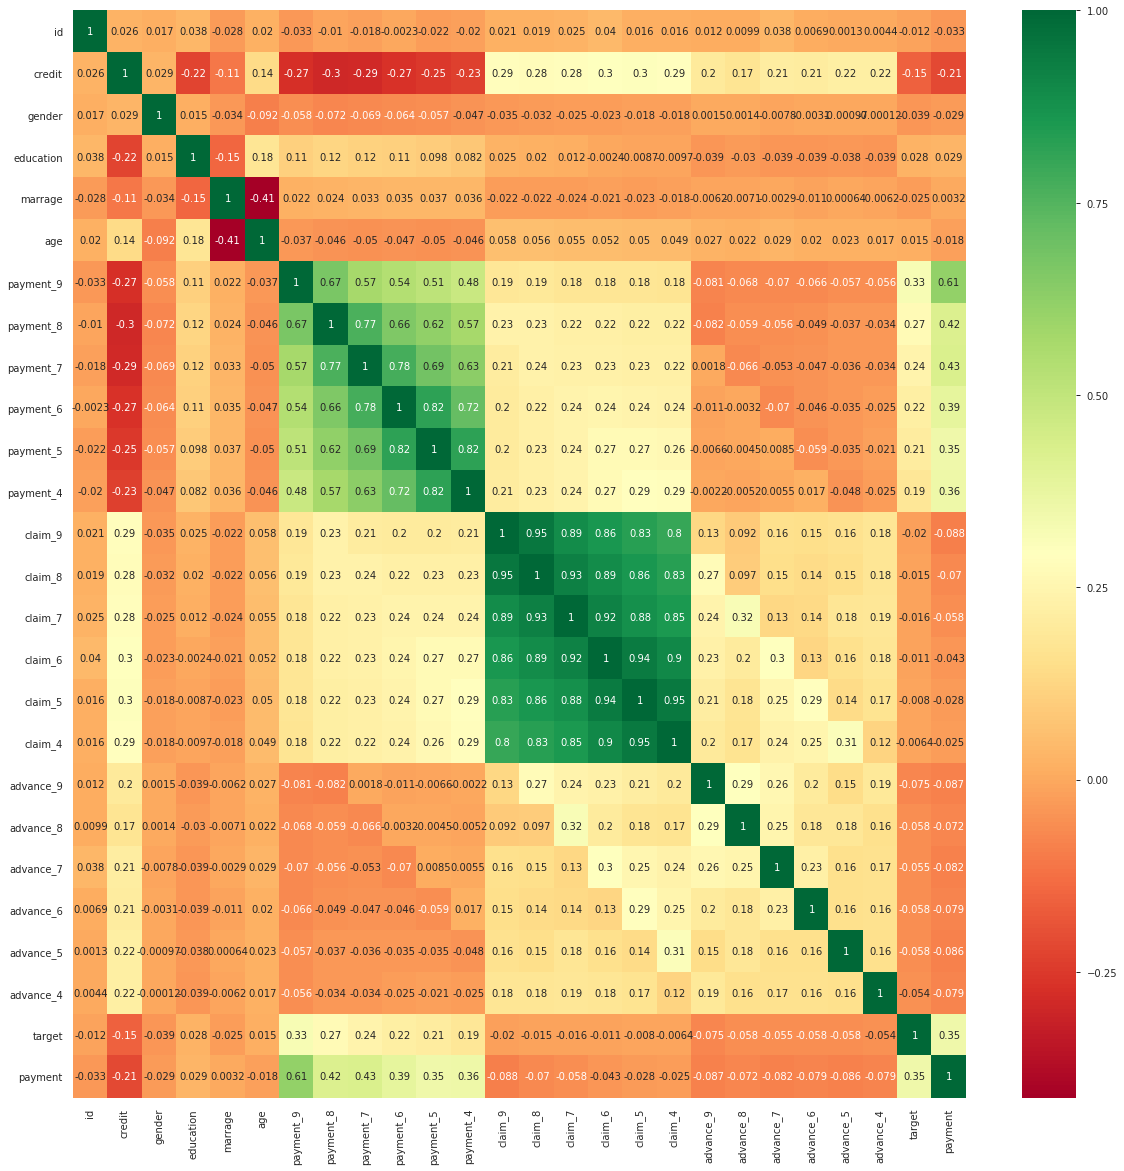

In [112]:
#とりあえず相関を見てみる
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["target"])>-10]
plt.figure(figsize=(20,20))
g = sns.heatmap(train[top_corr_features].corr(), annot = True, cmap="RdYlGn")

In [113]:
#NaNの対処
nuls = pd.DataFrame(train.isnull().sum().sort_values(ascending = False)[:10])
nuls.columns = ['Null Count']
nuls.index.name = 'Feature'
nuls

,Null Count
Feature,
recent_payment,0
claim_9,0
credit,0
gender,0
education,0
marrage,0
age,0
payment_9,0
payment_8,0


In [114]:
pdp.ProfileReport(train)

Number of variables,27
Number of observations,27000
Total Missing (%),0.0%
Total size in memory,5.6 MiB
Average record size in memory,216.0 B
Numeric,18
Categorical,0
Boolean,3
Date,0
Text (Unique),0
Rejected,6


In [115]:
train.dtypes
#gender education age target をカテゴリ型に変換したい

id                int64
credit            int64
gender            int64
education         int64
marrage           int64
age               int64
payment_9         int64
payment_8         int64
payment_7         int64
payment_6         int64
payment_5         int64
payment_4         int64
claim_9           int64
claim_8           int64
claim_7           int64
claim_6           int64
claim_5           int64
claim_4           int64
advance_9         int64
advance_8         int64
advance_7         int64
advance_6         int64
advance_5         int64
advance_4         int64
target            int64
payment           int64
recent_payment    int64
dtype: object

In [0]:
#トレーニングデータの分割
y = train.target 
X = train.drop(['id','target'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.20)

In [117]:
#xgb 0830 RMSE: 0.1801851851851852
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBClassifier(max_depth=7, learning_rate=0.05, n_estimators=100)


model_xgb.fit(X_train, y_train, verbose=False)
preds = model_xgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error( y_test, preds))))

	RMSE: 0.18037037037037038 


In [118]:
#xgbテストデータで予測したtarget値をCSVに出力
XGBMd = model_xgb.predict(test.drop(['id'], axis=1))

submit= pd.DataFrame()
submit['ID'] = test.id
submit['Y'] = XGBMd

submit.to_csv('xgb_submit.csv', index=False)
print('XGB submission file created')

XGB submission file created


In [119]:
#light gbm　0832 RMSE: 0.1787037037037037  
#we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(max_depth=7, learning_rate=0.05, num_leaves=31, n_estimators=100)


model_lgb.fit(X_train, y_train, verbose=False)
preds = model_lgb.predict(X_test)

print('{:^5}'.format("\tRMSE: ")
          +'{:<20}'.format(str(mean_squared_error(y_test, preds))))

	RMSE: 0.17814814814814814 


In [120]:
X_train.head(10)

,credit,gender,education,marrage,age,payment_9,payment_8,payment_7,payment_6,payment_5,...,claim_5,claim_4,advance_9,advance_8,advance_7,advance_6,advance_5,advance_4,payment,recent_payment
14672,180000,2,1,1,49,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
20803,100000,2,2,1,32,0,0,0,0,0,...,56849,45744,2749,4800,2000,2000,2000,2000,0,0
1329,280000,1,1,2,31,1,-2,-1,0,-1,...,6624,1489,0,4919,10,6657,1496,2244,1,0
8064,150000,1,3,2,29,1,3,2,2,2,...,52639,58508,0,0,4000,0,7127,0,1,0
19781,240000,2,1,2,26,-1,0,-1,-1,-1,...,6280,7619,1639,12450,28969,6280,7619,3000,0,0
6946,130000,2,2,1,43,0,0,0,0,0,...,80733,82883,5008,6003,4000,3000,4870,3000,0,0
14990,20000,1,2,1,27,0,0,0,-2,-2,...,0,0,2000,0,0,0,0,0,0,0
3448,70000,1,3,2,53,0,0,0,0,0,...,17618,18321,1497,1500,5000,1000,1000,1000,0,0
11262,50000,2,2,1,29,2,2,2,2,0,...,15865,23753,3800,1500,0,628,10362,786,1,0
1571,140000,2,2,2,29,-2,-2,-2,-2,-2,...,0,0,945,0,0,0,0,0,0,0


In [121]:
#lgbテストデータで予測したtarget値をCSVに出力
LGBMd = model_lgb.predict(test.drop(['id'], axis=1))

submit= pd.DataFrame()
submit['ID'] = test.id
submit['Y'] = LGBMd

submit.to_csv('lgb_submit.csv', index=False)
print('LGB submission file created')

LGB submission file created
